In [71]:
# ============================================================================
#                     Import the Libraries
# ============================================================================
from __future__ import annotations
import warnings
from urllib3.exceptions import NotOpenSSLWarning
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)
import time
import random
from typing import Dict, List, Set, Tuple
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import sklearn
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
!pip install gensim
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import random
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import issparse
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_samples

[nltk_data] Downloading package stopwords to /Users/sebas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sebas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [72]:
# ============================================================================
#                          Data Collection
# ============================================================================

# Configuration
SEED = 42
random.seed(SEED)
TARGET_PER_LABEL = 200
MIN_WORDS = 130  # Set to 130 as requested
MAX_WORDS = 150
YEAR_RANGE = "(2010[dp] : 2026[dp])"

QUERIES = {
    "a": '("Type 2 Diabetes" OR "T2D")',
    "b": '("Thyroid Cancer" OR "Hypothyroidism")',
    "c": '("Osteoporosis" OR "Bone Density")',
    "d": '("Polycystic Ovary Syndrome" OR "PCOS")',
    "e": '("Pituitary Adenoma" OR "Cushing Disease")'
}

def get_balanced_data():
    all_rows = []
    global_seen = set()

    for label, q in QUERIES.items():
        print(f"Fetching label {label} (Targeting {MIN_WORDS}-{MAX_WORDS} words)")
        # Increase retmax to 1000 to ensure we find enough long abstracts
        search_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={q} AND {YEAR_RANGE} AND hasabstract&retmax=1000&retmode=json"

        try:
            search_res = requests.get(search_url, timeout=30)
            search_res.raise_for_status()
            ids = search_res.json()['esearchresult']['idlist']

            # Fetch in batches of 200 to prevent 'no element found' errors from huge requests
            for i in range(0, len(ids), 200):
                if len([r for r in all_rows if r['label'] == label]) >= TARGET_PER_LABEL:
                    break

                batch_ids = ids[i:i+200]
                fetch_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={','.join(batch_ids)}&retmode=xml"

                response = requests.get(fetch_url, timeout=30)
                if not response.text.strip():
                    continue

                root = ET.fromstring(response.text)

                for article in root.findall(".//PubmedArticle"):
                    if len([r for r in all_rows if r['label'] == label]) >= TARGET_PER_LABEL:
                        break

                    pmid = article.find(".//PMID").text
                    if pmid in global_seen: continue

                    title_node = article.find(".//ArticleTitle")
                    title = "".join(title_node.itertext()) if title_node is not None else ""

                    abstract_node = article.find(".//AbstractText")
                    abstract = "".join(abstract_node.itertext()) if abstract_node is not None else ""

                    full_text = f"{title} {abstract}"
                    words = full_text.split()

                    if len(words) >= MIN_WORDS:
                        truncated_text = " ".join(words[:MAX_WORDS])
                        all_rows.append({
                            'pmid': pmid,
                            'label': label,
                            'title': title,
                            'abstract': abstract,
                            'text': truncated_text,
                            'word_count': len(truncated_text.split())
                        })
                        global_seen.add(pmid)

                time.sleep(0.5) # Pause between batches
        except Exception as e:
            print(f"Error fetching label {label}: {e}")
            continue

    return pd.DataFrame(all_rows)

df = get_balanced_data()
print("Data collection complete. Total records:", len(df))
df.to_csv("Research_Papers_MainFile.csv", index=False)


              

Fetching label a (Targeting 130-150 words)
Fetching label b (Targeting 130-150 words)
Fetching label c (Targeting 130-150 words)
Fetching label d (Targeting 130-150 words)
Fetching label e (Targeting 130-150 words)
Data collection complete. Total records: 1000


Dataset Shape: (1000, 6)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pmid        1000 non-null   object
 1   label       1000 non-null   object
 2   title       1000 non-null   object
 3   abstract    1000 non-null   object
 4   text        1000 non-null   object
 5   word_count  1000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 47.0+ KB
None

Duplicate PMIDs: 0
Duplicate Text content: 0


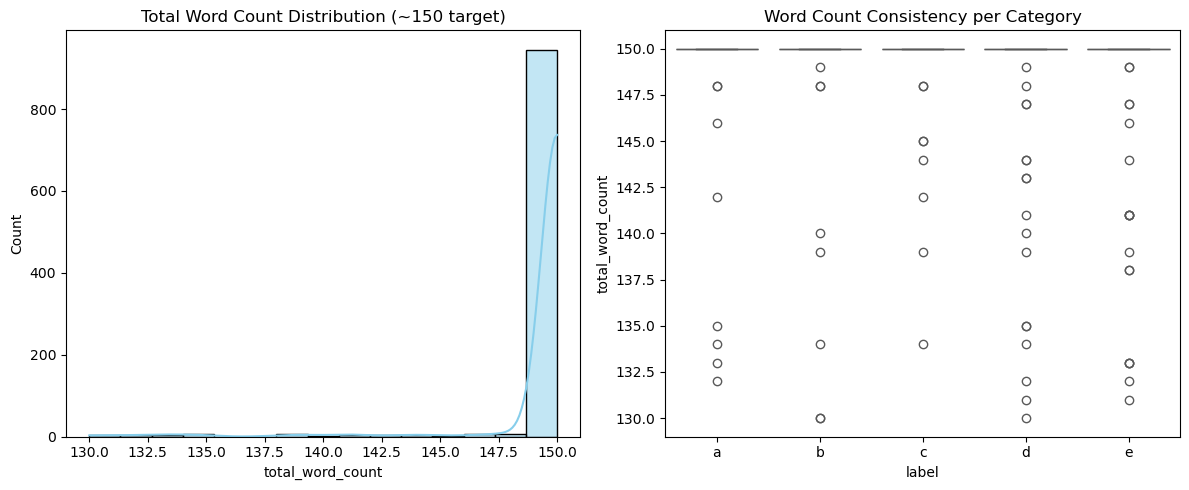

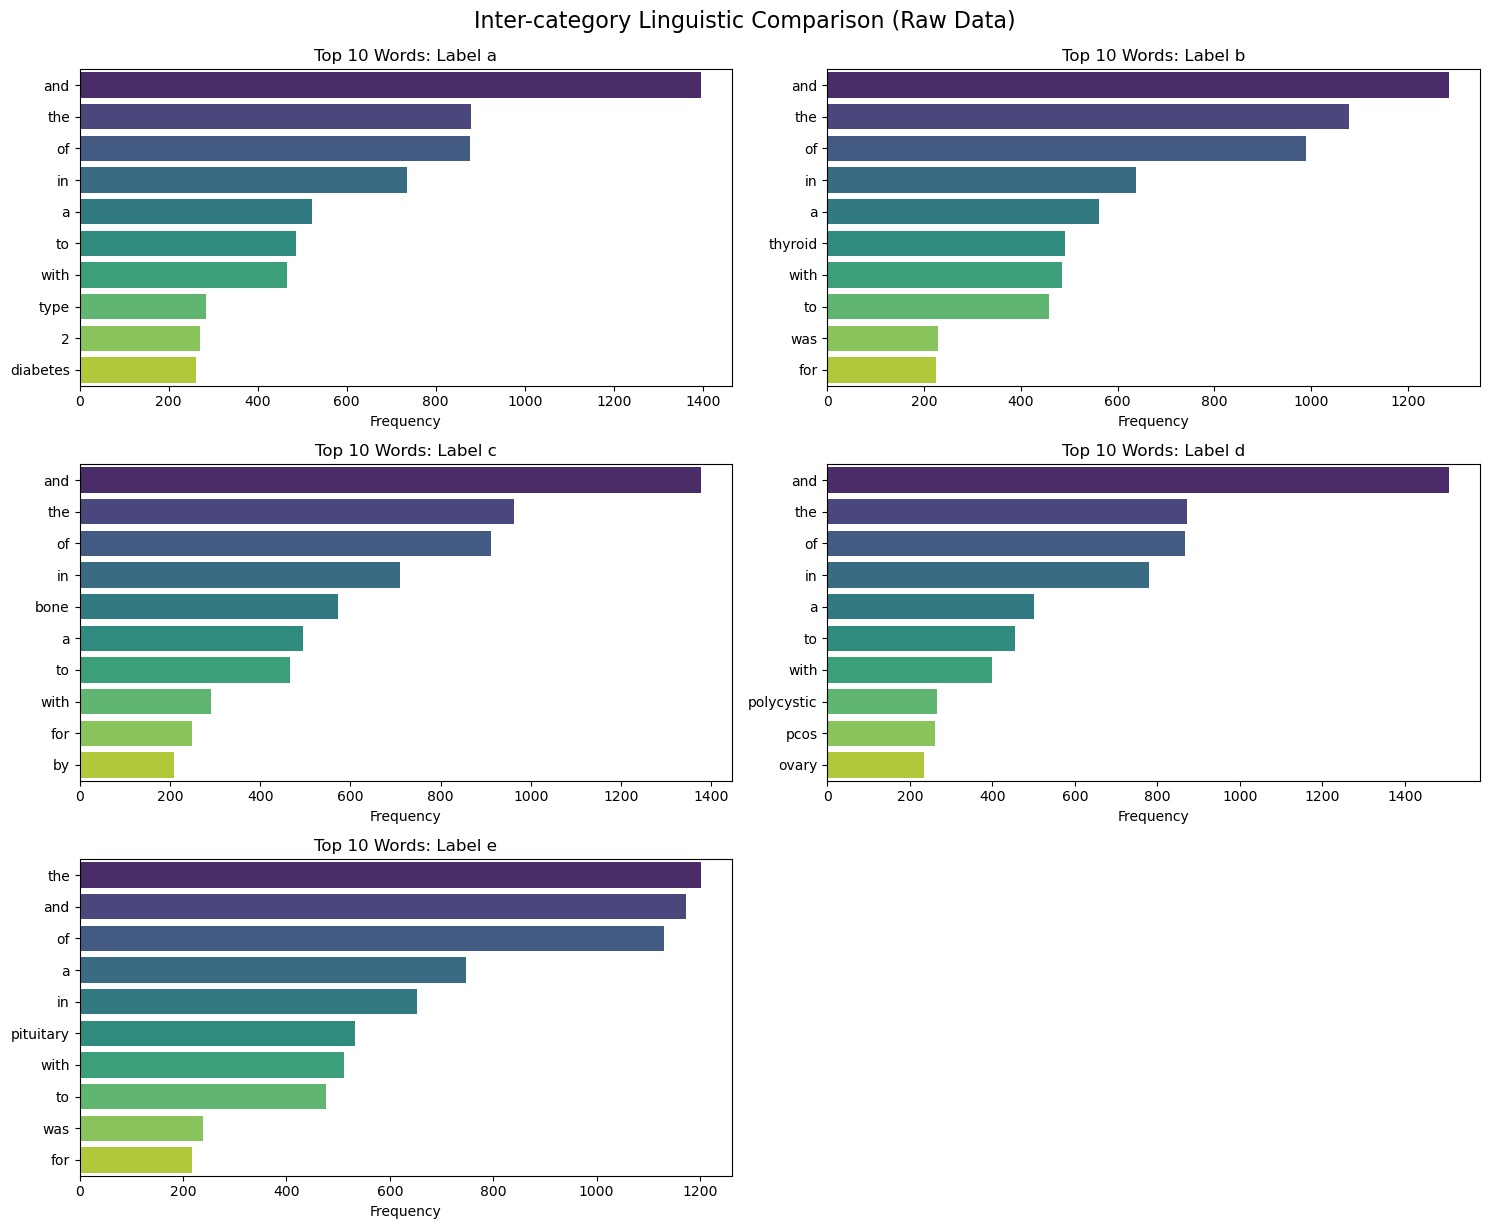

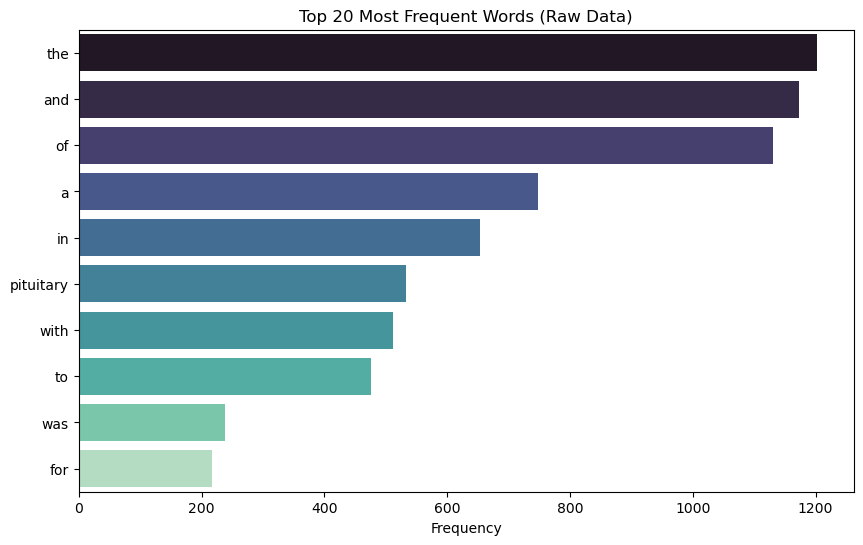


Word Count Statistics:
count    1000.000000
mean      149.436000
std         2.708365
min       130.000000
25%       150.000000
50%       150.000000
75%       150.000000
max       150.000000
Name: total_word_count, dtype: float64

Documents at 150-word limit: 941
Documents shorter than 150 words: 59


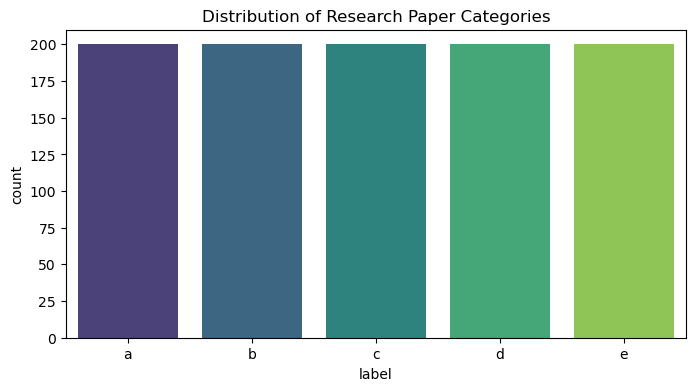

In [73]:
# ============================================================================
#                          Data Exploration
# ============================================================================

# 1. Structural Validation
print("Dataset Shape:", df.shape)
print("\nColumn Information:")
print(df.info())

# 2. Integrity Check: Ensure no data leakage or duplicates
duplicates = df.duplicated(subset=['pmid']).sum()
text_duplicates = df.duplicated(subset=['text']).sum()
print(f"\nDuplicate PMIDs: {duplicates}")
print(f"Duplicate Text content: {text_duplicates}")


# 3. Text Length Analysis (Calculate length for verification)
df['title_len'] = df['text'].apply(lambda x: len(x.split(". ")[0].split()))
df['total_word_count'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 5))

# Plot A: Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['total_word_count'], bins=15, color='skyblue', kde=True)
plt.title('Total Word Count Distribution (~150 target)')

# Plot B: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='total_word_count', data=df, hue='label', palette='Set2', legend=False)
plt.title('Word Count Consistency per Category')

plt.tight_layout()
plt.show()

# 4. Common Word Frequency ("Noisy" Words)
def get_most_common(text_series, top_n=20):
    all_words = " ".join(text_series).lower().split()
    return Counter(all_words).most_common(top_n)

top_words = get_most_common(df['text'])
words, counts = zip(*top_words)


# Linguistic Exploration: Top Keywords per Label
plt.figure(figsize=(15, 12))
labels = sorted(df['label'].unique())

for i, label in enumerate(labels, 1):
    plt.subplot(3, 2, i)

    # Filter text for this specific label
    label_text = " ".join(df[df['label'] == label]['text']).lower().split()

    # Count words (still raw, so stopwords will appear)
    common_words = Counter(label_text).most_common(10)
    words, counts = zip(*common_words)

    sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='viridis', legend=False)
    plt.title(f"Top 10 Words: Label {label}")
    plt.xlabel("Frequency")

plt.tight_layout()
plt.suptitle("Inter-category Linguistic Comparison (Raw Data)", fontsize=16, y=1.02)
plt.show()

# Plot C: Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='mako', legend=False)
plt.title("Top 20 Most Frequent Words (Raw Data)")
plt.xlabel("Frequency")
plt.show()

# 5. Statistical summary
print("\nWord Count Statistics:")
print(df['total_word_count'].describe())

at_limit = df[df['total_word_count'] == 150].shape[0]
below_limit = df[df['total_word_count'] < 150].shape[0]

print(f"\nDocuments at 150-word limit: {at_limit}")
print(f"Documents shorter than 150 words: {below_limit}")

# 6. Class Balance (FIXED: hue added to avoid Future Warning)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', hue='label', palette='viridis', legend=False)
plt.title("Distribution of Research Paper Categories")
plt.show()

Cleaning text... please wait.
Cleaning Complete!

--- Comparison ---
Original: Generative AI Uncovers Novel Chrebp/Txnip Axis Inhibitors with Potential Anti-inflammatory Activity. ...
Cleaned:  generative ai uncovers novel chrebptxnip axis inhibitor potential antiinflammatory activity type dia ...


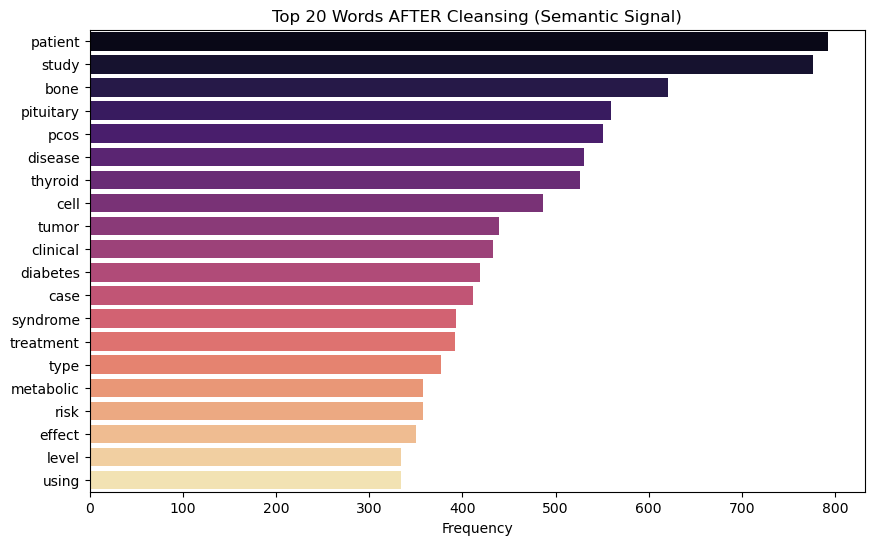

In [74]:
# ============================================================================
#                          Preprocessing & Data Cleansing
# ============================================================================

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove Punctuation and Numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 3. Tokenize and Remove Stopwords + Lemmatize
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    return " ".join(cleaned_tokens)

# Apply the cleaning to a new column
print("Cleaning text... please wait.")
df['cleaned_text'] = df['text'].apply(clean_text)
print("Cleaning Complete!")

# Show the difference
print("\n--- Comparison ---")
print("Original:", df['text'].iloc[0][:100], "...")
print("Cleaned: ", df['cleaned_text'].iloc[0][:100], "...")

# Re-running the Top 20 Word Frequency on the cleaned data
top_words_clean = get_most_common(df['cleaned_text'])
words_c, counts_c = zip(*top_words_clean)


plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts_c), y=list(words_c), hue=list(words_c), palette='magma', legend=False)
plt.title("Top 20 Words AFTER Cleansing (Semantic Signal)")
plt.xlabel("Frequency")
plt.show()

In [75]:

# ============================================================================
#                          Feature Engineering
# ============================================================================
""" We will be preparing three distinct feature sets to feed into the clustering algorithms.
Each addresses the "sparsity" and "co-occurrence" issues discussed in class. """


# Bag of Words (BoW): A simple frequency counter used as our baseline
bow_vec = CountVectorizer(max_features=1000, stop_words='english')
X_bow = bow_vec.fit_transform(df['cleaned_text']) # Assuming cleaned_text is your processed column
print("BoW Feature Shape:", X_bow.shape)

# TF-IDF captures the semantic signal of unique medical keywords
tfidf_vec = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vec.fit_transform(df['cleaned_text'])
print("TF-IDF Feature Shape:", X_tfidf.shape)

# We extract 5 topics to align with our 5 ground-truth categories (a-e)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
X_lda = lda.fit_transform(X_tfidf) # Often performed on top of TF-IDF or Count vectors
print("LDA Feature Shape:", X_lda.shape)

# Tagging documents for Doc2Vec training (Dense Embeddings)
# Prepare data
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(df['cleaned_text'])]
# Build and Train Model
# Using a fixed seed and workers=1 can prevent 'Exception Ignored' and ensure reproducibility
d2v_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=1, seed=42)
# Generate Vectors and convert to a NumPy array for the clustering algorithms
X_d2v = np.array([d2v_model.infer_vector(doc.split()) for doc in df['cleaned_text']])

print("Doc2Vec Feature Shape:", X_d2v.shape)



BoW Feature Shape: (1000, 1000)
TF-IDF Feature Shape: (1000, 1000)
LDA Feature Shape: (1000, 5)
Doc2Vec Feature Shape: (1000, 100)


In [76]:
# ============================================================================
#                          Clustering Algorithms
# ============================================================================
def train_clustering_models(feature_name, features):
    """
    Applies three distinct clustering algorithms to a given feature set.
    Ensures data is in dense format for GMM and Hierarchical models.
    """
    # Convert sparse matrices (like BoW/TF-IDF) to dense arrays for EM and HC
    dense_features = features.toarray() if hasattr(features, "toarray") else features

    print(f"--- Training Models for {feature_name} ---")

    # K-Means: Grouping by centroid distance
    km = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(features)

    # EM (Gaussian Mixture): Grouping by probability distributions
    em = GaussianMixture(n_components=5, random_state=42).fit_predict(dense_features)

    # Hierarchical: Grouping by connectivity/distance tree
    hc = AgglomerativeClustering(n_clusters=5).fit_predict(dense_features)

    return km, em, hc

# Applying to all 4 feature sets (added BoW as the first step)
df['km_bow'], df['em_bow'], df['hc_bow'] = train_clustering_models("BoW", X_bow)
df['km_tfidf'], df['em_tfidf'], df['hc_tfidf'] = train_clustering_models("TF-IDF", X_tfidf)
df['km_lda'], df['em_lda'], df['hc_lda'] = train_clustering_models("LDA", X_lda)
df['km_d2v'], df['em_d2v'], df['hc_d2v'] = train_clustering_models("Doc2Vec", X_d2v)

print("\nClustering Phase Complete!")

--- Training Models for BoW ---
--- Training Models for TF-IDF ---
--- Training Models for LDA ---
--- Training Models for Doc2Vec ---

Clustering Phase Complete!


In [77]:
# ============================================================================
#                          Cluster Evaluation
# ============================================================================
def calculate_metrics(y_true, y_pred, features):
    """
    Calculates Silhouette Score and aligned Cohen's Kappa.
    Uses the Hungarian Algorithm to solve the 'Correspondence' problem.
    """
    # 1. Silhouette Score: Measures how well-separated the machine's clusters are
    dense_feat = features.toarray() if hasattr(features, "toarray") else features
    sil = silhouette_score(dense_feat, y_pred)

    # 2. Label Alignment: Overlay actual labels on clusters to find best match
    # Convert true labels (a, b, c, d, e) to codes (0, 1, 2, 3, 4)
    true_num = df['label'].astype('category').cat.codes

    # Contingency matrix to compare cluster IDs vs True Label IDs
    cm = confusion_matrix(true_num, y_pred)

    # Use Hungarian Algorithm to map cluster 0-4 to labels a-e to maximize agreement
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}

    # Re-map the machine's predictions to match our label IDs
    y_pred_aligned = np.array([mapping[val] for val in y_pred])

    # 3. Cohen's Kappa: Measure real agreement between machine and human
    kappa = cohen_kappa_score(true_num, y_pred_aligned)

    return sil, kappa

# Iterate through all combinations including BOW
eval_data = []
feature_map = {"bow": X_bow, "tfidf": X_tfidf, "lda": X_lda, "d2v": X_d2v}

for feat in ["bow", "tfidf", "lda", "d2v"]:
    for algo in ["km", "em", "hc"]:
        col = f"{algo}_{feat}"
        # Fetch metrics using our alignment logic
        sil, kappa = calculate_metrics(df['label'], df[col], feature_map[feat])

        eval_data.append({
            "Feature": feat.upper(),
            "Algorithm": algo.upper(),
            "Silhouette": round(sil, 4),
            "Kappa": round(kappa, 4)
        })

# Create Summary DataFrame for Analysis
eval_df = pd.DataFrame(eval_data)
print("\n--- Final Evaluation Summary ---")
print(eval_df.sort_values(by="Kappa", ascending=False))


--- Final Evaluation Summary ---
   Feature Algorithm  Silhouette   Kappa
3    TFIDF        KM      0.0318  0.7363
1      BOW        EM      0.0490  0.7000
0      BOW        KM      0.0491  0.6888
2      BOW        HC      0.0412  0.6300
4    TFIDF        EM      0.0253  0.6013
5    TFIDF        HC      0.0163  0.5375
7      LDA        EM      0.2717  0.3175
6      LDA        KM      0.6107  0.3062
8      LDA        HC      0.5834  0.2862
11     D2V        HC      0.1377  0.2588
10     D2V        EM      0.1830  0.2575
9      D2V        KM      0.1904  0.2412


,Feature,Algorithm,Silhouette,Kappa
3,TFIDF,KM,0.0318,0.7363
1,BOW,EM,0.0490,0.7000
0,BOW,KM,0.0491,0.6888
2,BOW,HC,0.0412,0.6300
4,TFIDF,EM,0.0253,0.6013
5,TFIDF,HC,0.0163,0.5375
7,LDA,EM,0.2717,0.3175
6,LDA,KM,0.6107,0.3062
8,LDA,HC,0.5834,0.2862
11,D2V,HC,0.1377,0.2588


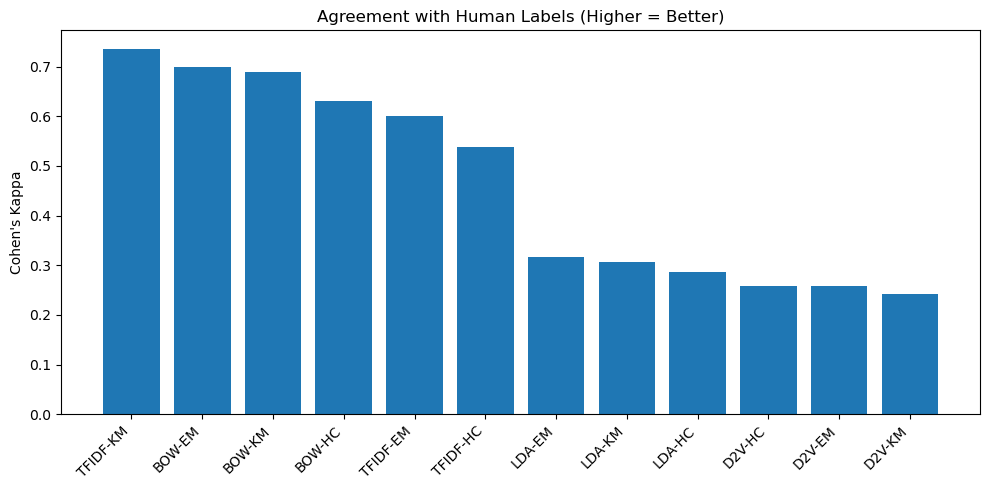

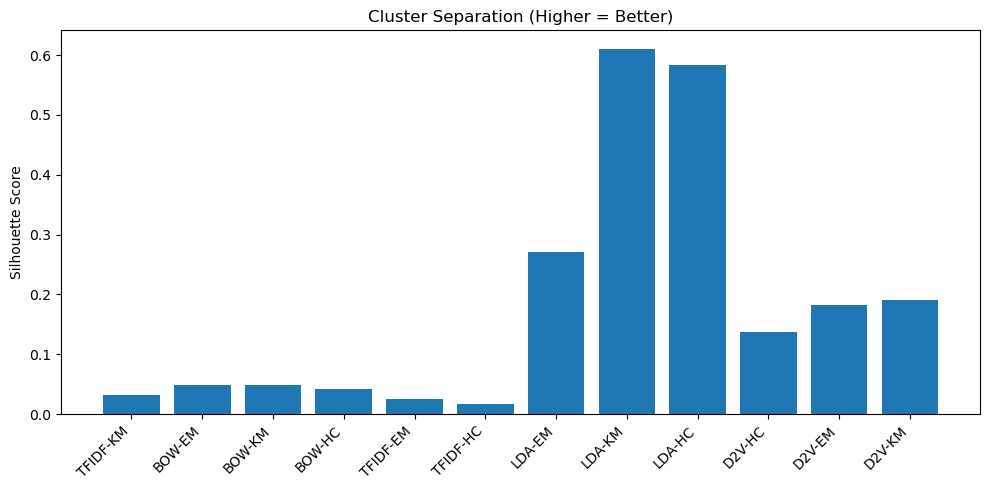

In [78]:
# ============================================================================
#Result Comparison
# ============================================================================

import matplotlib.pyplot as plt

# Sort results
results_sorted = eval_df.sort_values(
    ["Kappa", "Silhouette"],
    ascending=False
)

display(results_sorted)

# Bar chart for Kappa
plt.figure(figsize=(10,5))
x_labels = results_sorted["Feature"] + "-" + results_sorted["Algorithm"]
plt.bar(x_labels, results_sorted["Kappa"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cohen's Kappa")
plt.title("Agreement with Human Labels (Higher = Better)")
plt.tight_layout()
plt.show()

# Bar chart for Silhouette
plt.figure(figsize=(10,5))
plt.bar(x_labels, results_sorted["Silhouette"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Silhouette Score")
plt.title("Cluster Separation (Higher = Better)")
plt.tight_layout()
plt.show()

In [79]:
# ============================================================================
#                    Error Analysis - Best Model (TFIDF + KM)
# ============================================================================

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np

# True labels (numeric)
true_num = df['label'].astype('category').cat.codes
label_categories = df['label'].astype('category').cat.categories

# Raw cluster predictions
y_pred_raw = df["km_tfidf"]

# Confusion matrix
cm = confusion_matrix(true_num, y_pred_raw)

# Hungarian alignment
row_ind, col_ind = linear_sum_assignment(-cm)
mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Align predictions
y_pred_aligned = np.array([mapping[val] for val in y_pred_raw])

# Convert back to label letters
aligned_labels = [label_categories[i] for i in y_pred_aligned]

# Store in dataframe
df["predicted_label"] = aligned_labels

In [80]:
# ============================================================================
#                    Identify Missclassification
# ============================================================================

# Total errors
errors = df[df["label"] != df["predicted_label"]]
print("Total Misclassified Documents:", len(errors))

# Confusion breakdown
confusion = (
    errors.groupby(["label", "predicted_label"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(confusion.head(10))

Total Misclassified Documents: 211


,label,predicted_label,count
1,b,a,76
3,c,a,58
4,d,a,42
7,e,a,23
2,b,e,6
0,a,c,1
5,d,b,1
6,d,c,1
8,e,b,1
9,e,c,1


In [ ]:
# =========================
# ERROR ANALYSIS: b → a
# =========================
from sklearn.feature_extraction.text import CountVectorizer

def top_terms(texts, n=10, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words="english",
                          ngram_range=ngram_range,
                          min_df=2)
    X = vec.fit_transform(texts)
    freqs = X.sum(axis=0).A1
    terms = vec.get_feature_names_out()
    top_idx = freqs.argsort()[::-1][:n]
    return list(zip(terms[top_idx], freqs[top_idx]))

# Largest confusion pair
true_label = confusion.iloc[0]["label"]
wrong_label = confusion.iloc[0]["predicted_label"]

mis_docs = df[(df["label"] == true_label) &
              (df["predicted_label"] == wrong_label)]

correct_docs = df[(df["label"] == true_label) &
                  (df["predicted_label"] == true_label)]

print("Most common confusion:", true_label, "→", wrong_label)
print("Misclassified count:", len(mis_docs))
print("Correct count:", len(correct_docs))

print("\nTop unigrams in MISCLASSIFIED docs:")
print(top_terms(mis_docs["cleaned_text"].tolist(), 10, (1,1)))

print("\nTop unigrams in CORRECT docs:")
print(top_terms(correct_docs["cleaned_text"].tolist(), 10, (1,1)))

print("\nTop bigrams in MISCLASSIFIED docs:")
print(top_terms(mis_docs["cleaned_text"].tolist(), 10, (2,2)))

print("\nTop bigrams in CORRECT docs:")
print(top_terms(correct_docs["cleaned_text"].tolist(), 10, (2,2)))

Most common confusion: b → a
Misclassified count: 76
Correct count: 118

Top unigrams in MISCLASSIFIED docs:
[('hypothyroidism', np.int64(113)), ('study', np.int64(67)), ('patient', np.int64(63)), ('case', np.int64(48)), ('disease', np.int64(46)), ('thyroid', np.int64(39)), ('hormone', np.int64(38)), ('clinical', np.int64(37)), ('syndrome', np.int64(35)), ('report', np.int64(30))]

Top unigrams in CORRECT docs:
[('thyroid', np.int64(456)), ('cancer', np.int64(184)), ('patient', np.int64(120)), ('carcinoma', np.int64(105)), ('study', np.int64(84)), ('tumor', np.int64(82)), ('analysis', np.int64(69)), ('case', np.int64(68)), ('papillary', np.int64(66)), ('ptc', np.int64(66))]

Top bigrams in MISCLASSIFIED docs:
[('case report', np.int64(14)), ('thyroid hormone', np.int64(14)), ('cohort study', np.int64(12)), ('diabetes mellitus', np.int64(12)), ('adverse event', np.int64(11)), ('study aimed', np.int64(10)), ('thyroidstimulating hormone', np.int64(9)), ('newborn screening', np.int64(8)), 

In [86]:
# =========================
# ERROR ANALYSIS: c → a
# =========================

true_label = "c"
wrong_label = "a"

mis_c = df[(df["label"] == true_label) &
           (df["predicted_label"] == wrong_label)]

correct_c = df[(df["label"] == true_label) &
               (df["predicted_label"] == true_label)]

print("\n===== CONFUSION: c → a =====")
print("Misclassified count:", len(mis_c))
print("Correct count:", len(correct_c))

print("\nTop unigrams in MISCLASSIFIED:")
print(top_terms(mis_c["cleaned_text"].astype(str).tolist(), 10, (1,1)))

print("\nTop unigrams in CORRECT:")
print(top_terms(correct_c["cleaned_text"].astype(str).tolist(), 10, (1,1)))

print("\nTop bigrams in MISCLASSIFIED:")
print(top_terms(mis_c["cleaned_text"].astype(str).tolist(), 10, (2,2)))

print("\nTop bigrams in CORRECT:")
print(top_terms(correct_c["cleaned_text"].astype(str).tolist(), 10, (2,2)))


# =========================
# ERROR ANALYSIS: d → a
# =========================

true_label = "d"
wrong_label = "a"

mis_d = df[(df["label"] == true_label) &
           (df["predicted_label"] == wrong_label)]

correct_d = df[(df["label"] == true_label) &
               (df["predicted_label"] == true_label)]

print("\n===== CONFUSION: d → a =====")
print("Misclassified count:", len(mis_d))
print("Correct count:", len(correct_d))

print("\nTop unigrams in MISCLASSIFIED:")
print(top_terms(mis_d["cleaned_text"].astype(str).tolist(), 10, (1,1)))

print("\nTop unigrams in CORRECT:")
print(top_terms(correct_d["cleaned_text"].astype(str).tolist(), 10, (1,1)))

print("\nTop bigrams in MISCLASSIFIED:")
print(top_terms(mis_d["cleaned_text"].astype(str).tolist(), 10, (2,2)))

print("\nTop bigrams in CORRECT:")
print(top_terms(correct_d["cleaned_text"].astype(str).tolist(), 10, (2,2)))


===== CONFUSION: c → a =====
Misclassified count: 58
Correct count: 142

Top unigrams in MISCLASSIFIED:
[('study', np.int64(50)), ('osteoporosis', np.int64(45)), ('patient', np.int64(45)), ('fracture', np.int64(44)), ('disease', np.int64(43)), ('risk', np.int64(39)), ('case', np.int64(27)), ('treatment', np.int64(25)), ('clinical', np.int64(24)), ('health', np.int64(23))]

Top unigrams in CORRECT:
[('bone', np.int64(568)), ('osteoporosis', np.int64(203)), ('study', np.int64(117)), ('fracture', np.int64(101)), ('density', np.int64(95)), ('cell', np.int64(93)), ('using', np.int64(77)), ('effect', np.int64(77)), ('mineral', np.int64(69)), ('osteoblast', np.int64(66))]

Top bigrams in MISCLASSIFIED:
[('breast cancer', np.int64(11)), ('gut microbiota', np.int64(9)), ('risk factor', np.int64(8)), ('narrative review', np.int64(7)), ('systematic review', np.int64(7)), ('fragility fracture', np.int64(6)), ('hormone therapy', np.int64(6)), ('quality life', np.int64(6)), ('review metaanalysis', 

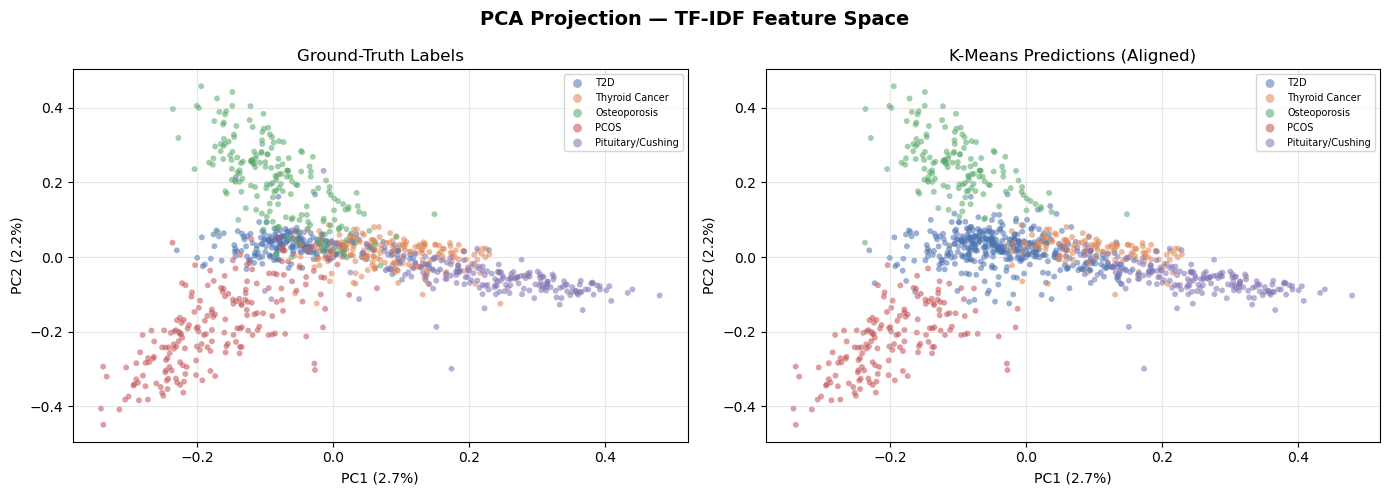

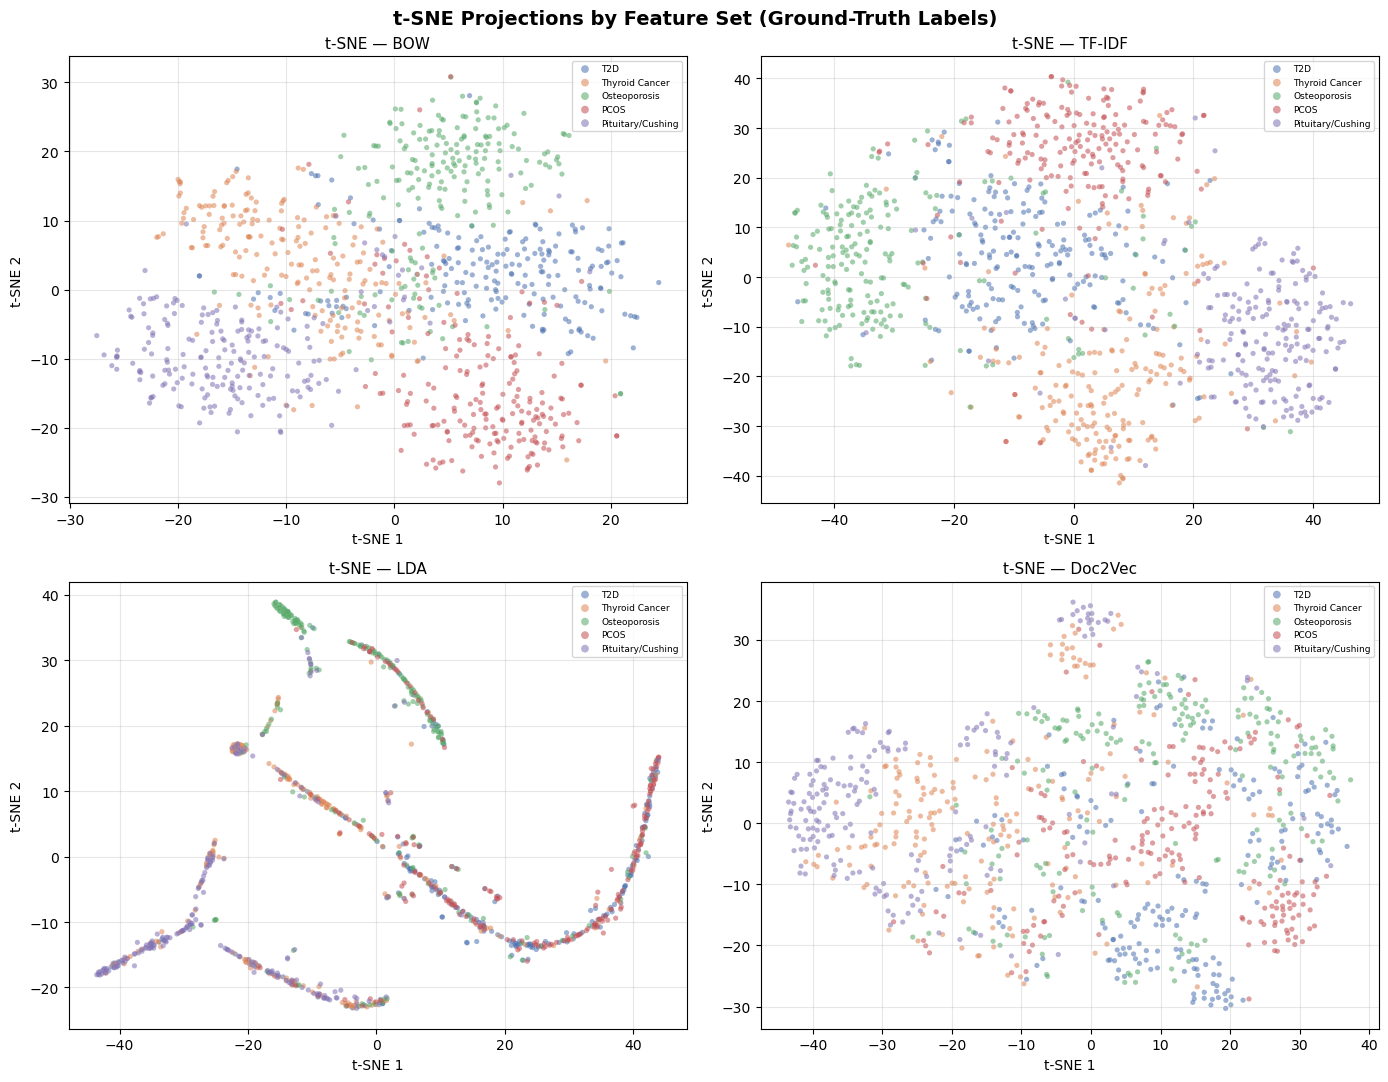

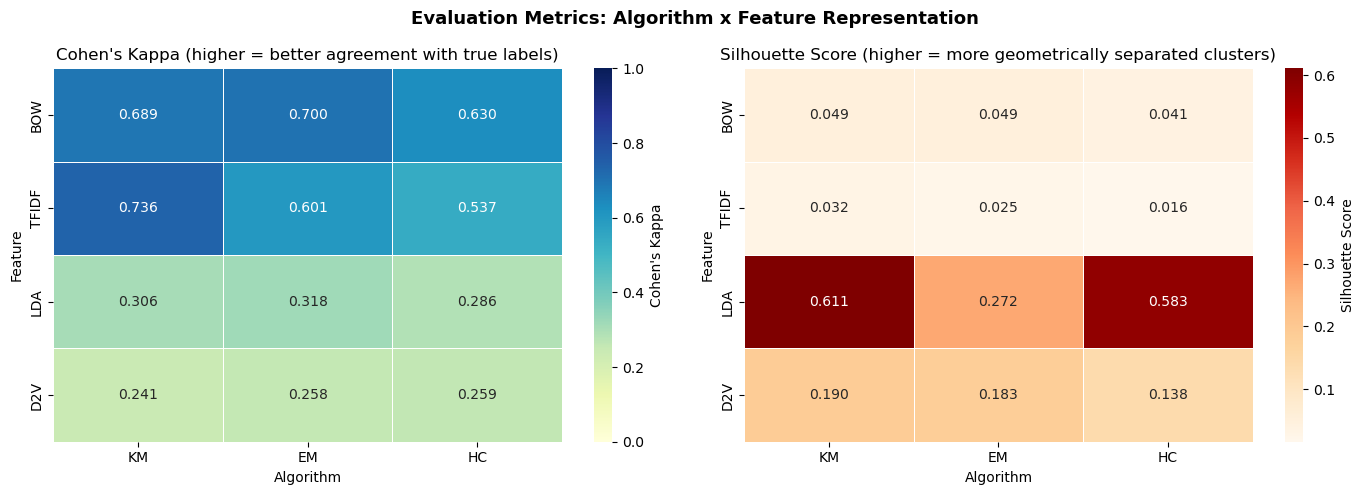

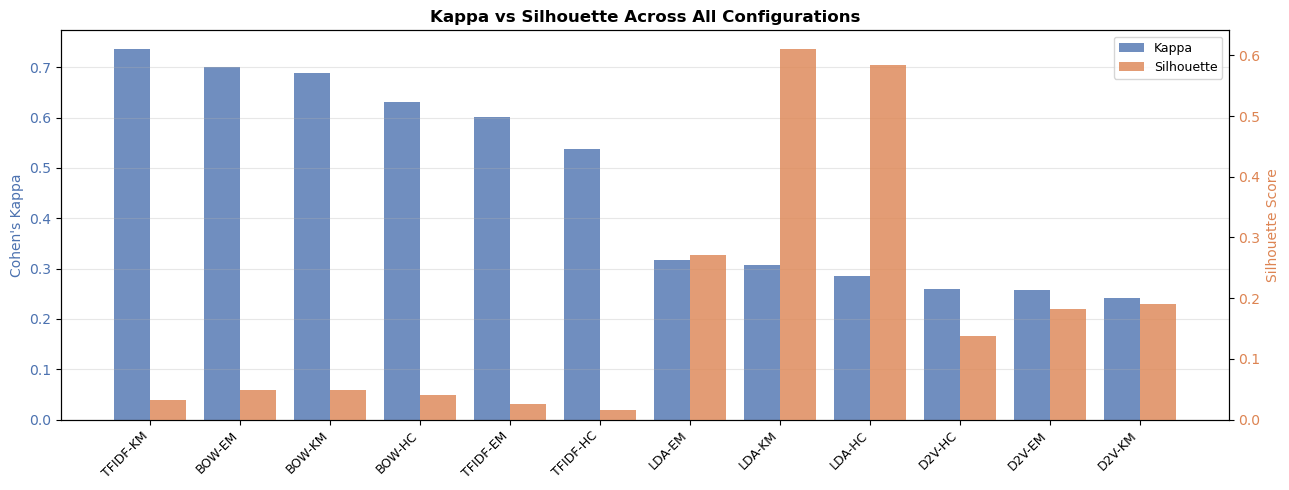

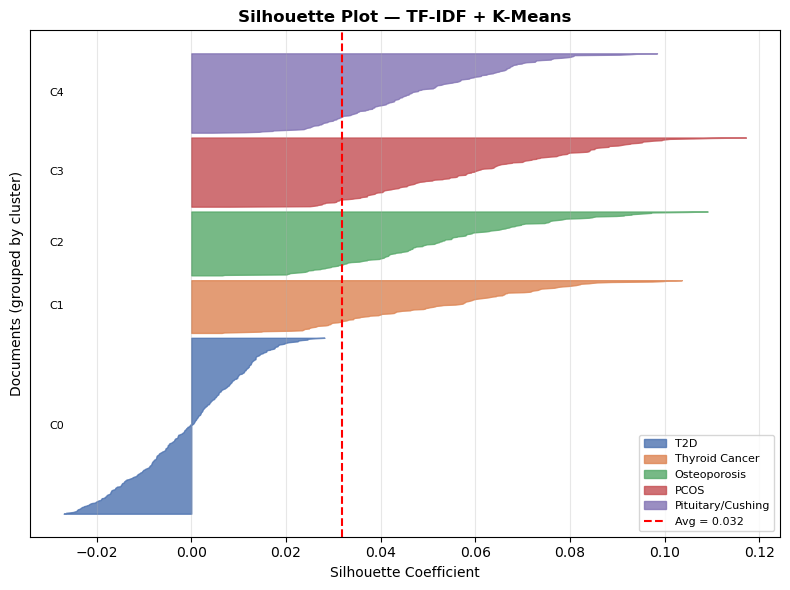

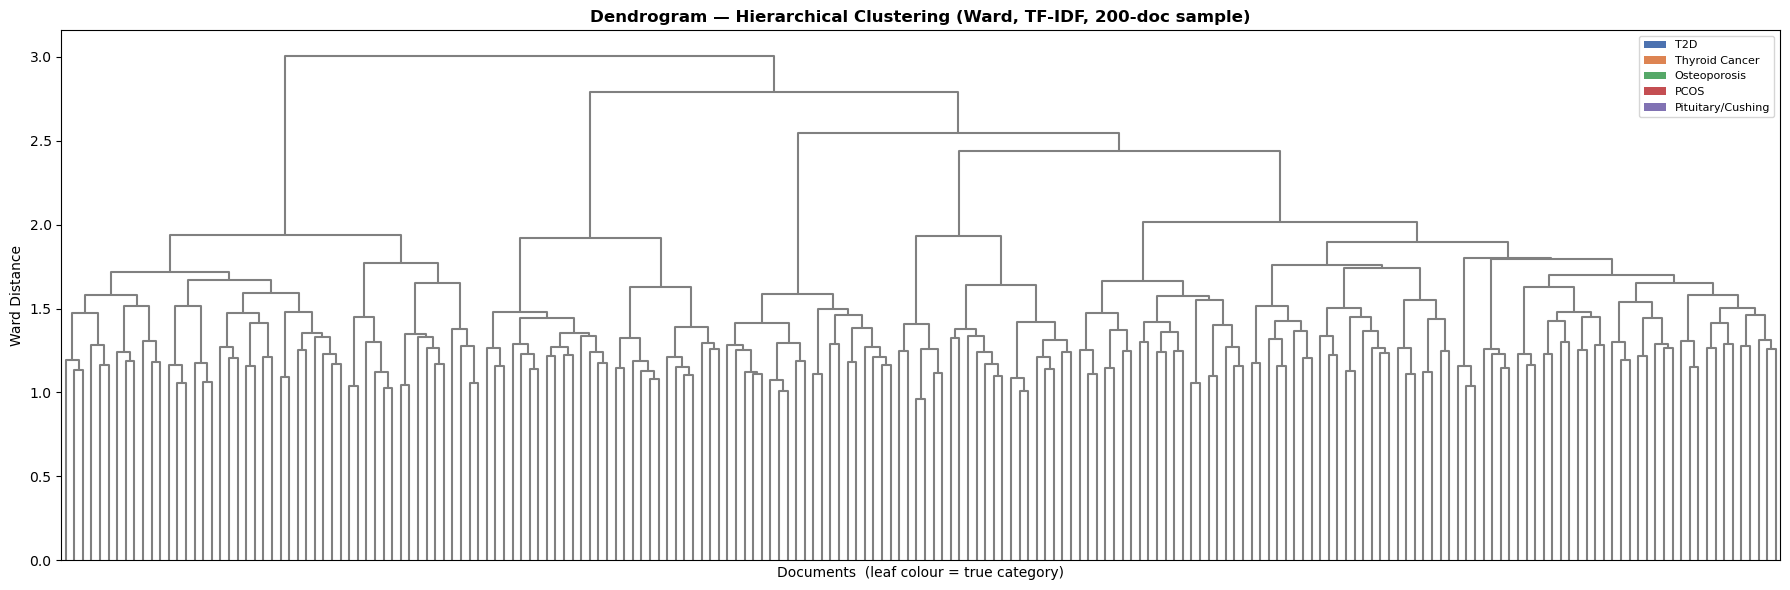

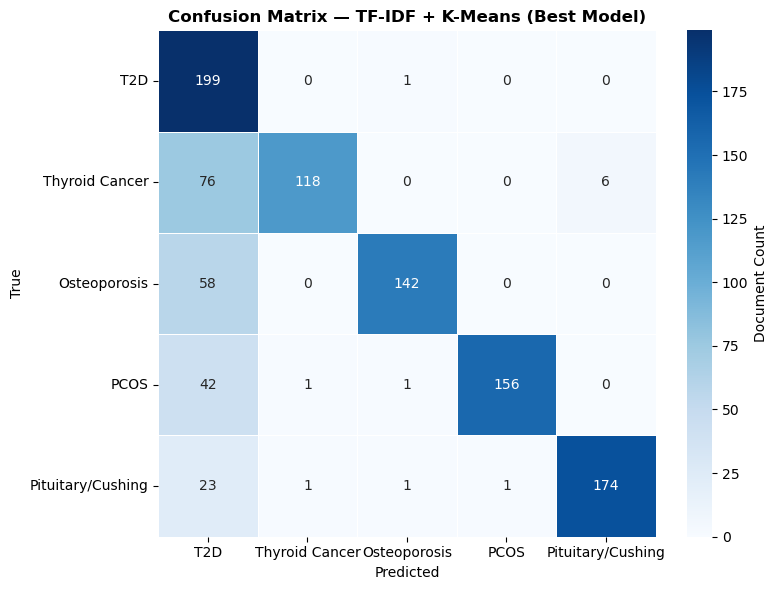

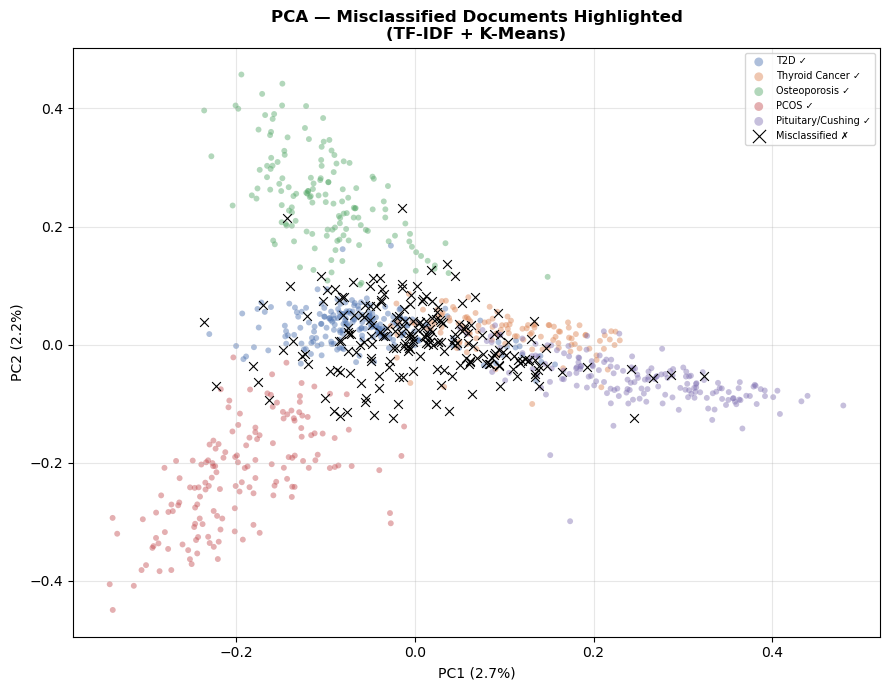

In [83]:
# ============================================================================
#                       SECTION 8 — VISUALIZATIONS
# ============================================================================
# Plots included:
#  1. PCA scatter: True vs Predicted labels (best model)
#  2. t-SNE for all 4 feature sets (true labels)
#  3. Kappa & Silhouette heatmaps (Feature x Algorithm)
#  4. Grouped bar chart: Kappa vs Silhouette
#  5. Silhouette plot per cluster (best model)
#  6. Dendrogram (Hierarchical Clustering, Ward, 200-doc sample)
#  7. Confusion Matrix heatmap (best model)
#  8. PCA with misclassified documents highlighted
# ============================================================================

# ─── Shared Configuration
# Fixed colour for each of the 5 categories — used consistently across all plots
PALETTE   = ["#4C72B0","#DD8452","#55A868","#C44E52","#8172B3"]

# Maps internal label letters (a-e) to human-readable category names
LABEL_MAP = {"a":"T2D","b":"Thyroid Cancer","c":"Osteoporosis",
             "d":"PCOS","e":"Pituitary/Cushing"}

# Fixed ordering of categories so colours and legends are consistent everywhere
CAT_ORDER = ["a","b","c","d","e"]

def to_dense(X):
    """Convert sparse matrices (BoW/TF-IDF) to dense NumPy arrays.
    PCA, t-SNE, silhouette, and linkage all require dense input."""
    return X.toarray() if issparse(X) else np.array(X)

# ─── Pre-compute aligned predictions
# The Hungarian algorithm in Cell 8 produced a 'mapping' dict that re-labels
# raw K-Means cluster IDs (0-4) to match the true category ordering.
# We apply that mapping here to get numerically aligned predictions.
y_pred_num = np.array([mapping[v] for v in df["km_tfidf"]])

# Boolean mask: True for every document that was assigned the wrong cluster
misclassified = df["label"] != df["predicted_label"]

# ─── PCA on TF-IDF (shared across Plot 1 and Plot 8)
# We reduce from 1000 TF-IDF dimensions to 2 principal components.
# The same pca2 object is reused in Plot 8 so both plots share the same axes.
pca2  = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(to_dense(X_tfidf))
ev    = pca2.explained_variance_ratio_   # used in axis labels (e.g. "PC1 (2.7%)")

# ============================================================
# PLOT 1 — PCA: True Labels vs Predicted Labels
# Goal: visually confirm that K-Means recovered the true structure
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("PCA Projection — TF-IDF Feature Space", fontsize=14, fontweight="bold")

# Loop over both panels: left = ground truth, right = model predictions
for ax, col, title in [
    (axes[0], "label",           "Ground-Truth Labels"),
    (axes[1], "predicted_label", "K-Means Predictions (Aligned)")]:

    for i, lbl in enumerate(CAT_ORDER):
        mask = df[col] == lbl                         # select rows for this category
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=PALETTE[i], label=LABEL_MAP[lbl],
                   alpha=0.55, s=18, edgecolors="none")

    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({ev[0]*100:.1f}%)")          # show % variance explained
    ax.set_ylabel(f"PC2 ({ev[1]*100:.1f}%)")
    ax.legend(fontsize=7, markerscale=1.5)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2 — t-SNE for all 4 feature sets
# Goal: compare how well each feature type separates categories visually
# ============================================================

# Dictionary of all four feature matrices (converted to dense where needed)
feature_sets = {
    "BOW":     to_dense(X_bow),
    "TF-IDF":  to_dense(X_tfidf),
    "LDA":     to_dense(X_lda),
    "Doc2Vec": to_dense(X_d2v)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle("t-SNE Projections by Feature Set (Ground-Truth Labels)",
             fontsize=14, fontweight="bold")

for ax, (fname, Xf) in zip(axes.flatten(), feature_sets.items()):

    # t-SNE reduces to 2D while preserving local neighbourhood structure.
    # init='pca' speeds up convergence and produces more stable layouts.
    # perplexity=30 is standard for datasets of ~1000 documents.
    Xt = TSNE(n_components=2, random_state=42, perplexity=30,
              n_iter=1000, init="pca", learning_rate="auto").fit_transform(Xf)

    for i, lbl in enumerate(CAT_ORDER):
        mask = df["label"] == lbl
        ax.scatter(Xt[mask, 0], Xt[mask, 1],
                   c=PALETTE[i], label=LABEL_MAP[lbl],
                   alpha=0.55, s=14, edgecolors="none")

    ax.set_title(f"t-SNE — {fname}", fontsize=11)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(fontsize=6.5, markerscale=1.5)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 3 — Kappa & Silhouette Heatmaps (Feature x Algorithm)
# Goal: show all 12 combinations at a glance to identify the best config
# ============================================================

# Define display order for rows (features) and columns (algorithms)
feat_order = ["BOW", "TFIDF", "LDA", "D2V"]
algo_order = ["KM",  "EM",    "HC"]

# Pivot eval_df from long format into a 4x3 matrix for the heatmap
pivot_k = eval_df.pivot(index="Feature", columns="Algorithm", values="Kappa"
          ).reindex(index=feat_order, columns=algo_order)

pivot_s = eval_df.pivot(index="Feature", columns="Algorithm", values="Silhouette"
          ).reindex(index=feat_order, columns=algo_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Evaluation Metrics: Algorithm x Feature Representation",
             fontsize=13, fontweight="bold")

# Kappa heatmap: vmin=0, vmax=1 anchors the colour scale to the full Kappa range
sns.heatmap(pivot_k, ax=axes[0], annot=True, fmt=".3f", cmap="YlGnBu",
            linewidths=0.5, vmin=0, vmax=1,
            cbar_kws={"label": "Cohen's Kappa"})
axes[0].set_title("Cohen's Kappa (higher = better agreement with true labels)")

# Silhouette heatmap: no fixed vmin/vmax — lets the range reflect actual spread
sns.heatmap(pivot_s, ax=axes[1], annot=True, fmt=".3f", cmap="OrRd",
            linewidths=0.5,
            cbar_kws={"label": "Silhouette Score"})
axes[1].set_title("Silhouette Score (higher = more geometrically separated clusters)")

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 4 — Grouped Bar Chart: Kappa vs Silhouette
# Goal: highlight the contradiction — high Silhouette does NOT mean high Kappa
# ============================================================

# Sort by Kappa descending so the best-performing configs appear on the left
eval_sorted = eval_df.sort_values("Kappa", ascending=False).reset_index(drop=True)
x_labels_s  = eval_sorted["Feature"] + "-" + eval_sorted["Algorithm"]
x_pos = np.arange(len(eval_sorted))
w = 0.4   # bar width — narrow enough to fit two bars side by side per tick

fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()   # second y-axis for Silhouette (different scale to Kappa)

# Kappa bars on left y-axis (blue), shifted left of centre
ax1.bar(x_pos - w/2, eval_sorted["Kappa"],      w, color="#4C72B0", alpha=0.8, label="Kappa")
# Silhouette bars on right y-axis (orange), shifted right of centre
ax2.bar(x_pos + w/2, eval_sorted["Silhouette"], w, color="#DD8452", alpha=0.8, label="Silhouette")

ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels_s, rotation=45, ha="right", fontsize=9)
ax1.set_ylabel("Cohen's Kappa",    color="#4C72B0")
ax2.set_ylabel("Silhouette Score", color="#DD8452")
ax1.set_title("Kappa vs Silhouette Across All Configurations",
              fontsize=12, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="#4C72B0")
ax2.tick_params(axis="y", labelcolor="#DD8452")

# Merge legends from both axes into one
l1, lbl1 = ax1.get_legend_handles_labels()
l2, lbl2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lbl1 + lbl2, loc="upper right", fontsize=9)
ax1.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 5 — Per-Cluster Silhouette Plot (TF-IDF + KM)
# Goal: show how confidently each document belongs to its assigned cluster
# ============================================================

# Compute per-document silhouette scores for the best model
sil_vals = silhouette_samples(to_dense(X_tfidf), y_pred_num)

fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10   # starting y-position for the first blade

for i in range(5):
    # Extract scores for cluster i and sort ascending for the blade shape
    vals    = np.sort(sil_vals[y_pred_num == i])
    y_upper = y_lower + len(vals)

    # Fill between 0 and each document's score to create the blade shape
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                     facecolor=PALETTE[i], edgecolor=PALETTE[i],
                     alpha=0.8, label=LABEL_MAP[CAT_ORDER[i]])

    # Label the cluster number at the vertical midpoint of its blade
    ax.text(-0.03, y_lower + 0.5 * len(vals), f"C{i}", fontsize=8, va="center")
    y_lower = y_upper + 10   # add a small gap between blades

# Red dashed line shows the dataset-wide average silhouette score
avg = sil_vals.mean()
ax.axvline(avg, color="red", linestyle="--", lw=1.5, label=f"Avg = {avg:.3f}")

ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Documents (grouped by cluster)")
ax.set_title("Silhouette Plot — TF-IDF + K-Means", fontweight="bold")
ax.legend(fontsize=8)
ax.set_yticks([])        # hide y-axis ticks — position has no numerical meaning
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 6 — Dendrogram (200-doc sample, Ward linkage, TF-IDF)
# Goal: show the merging tree of hierarchical clustering
# ============================================================

# Sample 200 documents to keep the dendrogram readable (full 1000 is too dense)
np.random.seed(42)
sidx     = np.random.choice(len(df), size=200, replace=False)
Xs       = to_dense(X_tfidf)[sidx]
labels_s = df["label"].iloc[sidx].values

# Build the linkage matrix using Ward's method
# Ward minimises the total within-cluster variance at each merge step
Z = linkage(Xs, method="ward")

fig, ax = plt.subplots(figsize=(18, 6))

# Draw the dendrogram; color_threshold=0 disables scipy's auto-colouring
# so we can apply our own category colours to the leaf tick marks instead
ddata = dendrogram(Z, ax=ax, no_labels=True, color_threshold=0,
                   above_threshold_color="grey")

# Map each leaf position to its true category colour
leaf_colors = [PALETTE[CAT_ORDER.index(l)] for l in labels_s]
for tick, leaf_idx in zip(ax.get_xticklabels(), ddata["leaves"]):
    tick.set_color(leaf_colors[leaf_idx])

ax.set_title("Dendrogram — Hierarchical Clustering (Ward, TF-IDF, 200-doc sample)",
             fontsize=12, fontweight="bold")
ax.set_xlabel("Documents  (leaf colour = true category)")
ax.set_ylabel("Ward Distance")

# Manual legend since we coloured leaves ourselves (not via scipy)
legend_els = [Patch(facecolor=PALETTE[i], label=LABEL_MAP[CAT_ORDER[i]])
              for i in range(5)]
ax.legend(handles=legend_els, fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 7 — Confusion Matrix Heatmap (best model)
# Goal: show exact counts of correct and incorrect assignments per category
# ============================================================

# Build a 5x5 confusion matrix in the fixed CAT_ORDER so rows/cols are consistent
cm    = confusion_matrix(df["label"], df["predicted_label"], labels=CAT_ORDER)
cm_df = pd.DataFrame(
    cm,
    index  =[LABEL_MAP[l] for l in CAT_ORDER],   # rows = true labels
    columns=[LABEL_MAP[l] for l in CAT_ORDER]    # cols = predicted labels
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5, ax=ax,
            cbar_kws={"label": "Document Count"})
ax.set_title("Confusion Matrix — TF-IDF + K-Means (Best Model)",
             fontsize=12, fontweight="bold")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 8 — PCA with Misclassified Documents Highlighted
# Goal: show WHERE in the feature space errors occur (boundaries vs centres)
# ============================================================

fig, ax = plt.subplots(figsize=(9, 7))

# First layer: correctly classified documents, coloured by true category
for i, lbl in enumerate(CAT_ORDER):
    mask = (df["label"] == lbl) & ~misclassified
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=PALETTE[i], label=f"{LABEL_MAP[lbl]} ✓",
               alpha=0.45, s=18, edgecolors="none")

# Second layer: misclassified documents drawn on top as black X markers
# zorder=5 ensures they are drawn above the coloured dots
ax.scatter(X_pca[misclassified, 0], X_pca[misclassified, 1],
           c="black", marker="x", s=40, lw=0.8,
           label="Misclassified ✗", zorder=5)

ax.set_title("PCA — Misclassified Documents Highlighted\n(TF-IDF + K-Means)",
             fontsize=12, fontweight="bold")
ax.set_xlabel(f"PC1 ({ev[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({ev[1]*100:.1f}%)")
ax.legend(fontsize=7, markerscale=1.5)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

